In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
from imgaug import augmenters 
from numpy import loadtxt
import numpy as np
from pylab import rcParams
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
import os
import tensorflow as tf

# LOAD DATASETS

In [0]:
def load_dataset(batch_size=1000):
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
    # Normalizing the images to the range of [0., 1.]
    train_images /= 255.
    test_images /= 255.

    TRAIN_BUF = 60000
    TEST_BUF = 10000

    BATCH_SIZE = batch_size
    # convert dataset to batches of data 
    train_dataset_image = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)
    train_dataset_label = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)
    train_dataset = tf.data.Dataset.zip((train_dataset_image, train_dataset_label)).shuffle(TRAIN_BUF)

    test_dataset_image = tf.data.Dataset.from_tensor_slices(test_images).batch(BATCH_SIZE)
    test_dataset_label = tf.data.Dataset.from_tensor_slices(test_labels).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.zip((test_dataset_image, test_dataset_label)).shuffle(TEST_BUF)

    return train_dataset, test_dataset

# PLOT 

In [0]:
# regenerate images from test set 
# 5 indicative images are reconstructed 
def plot_reconstructed_test_data(model, test_dataset):
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input)) 
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

In [0]:
# latent space distribution 
# lor latent dim 2 
def latent_space_distribution(model, test_dataset):
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z, _ = model.encode(x_input)
    labels = y_input.numpy()
    z1, z2 = z.numpy().T[0], z.numpy().T[1]

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
    cs = [colors[y] for y in labels]
    classes = list(range(10))

    recs = []
    for i in range(0, len(cs)):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=cs[i]))

    fig_dist = plt.figure(figsize=(8, 8))
    ax_dist = fig_dist.add_subplot(111)
    ax_dist.legend(recs, classes, loc=0)
    ax_dist.scatter(z1, z2, color=cs)


In [0]:
# generate images giving to the decoder a latent vector 
def generated_images(model, test_dataset):
    n = 20
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i, z1 in enumerate(np.linspace(-2, 2, n)):
        for j, z2 in enumerate(np.linspace(-2, 2, n)):
            z = np.array([[z1, z2]])
            generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
            axarr[i, j].axis('off')
            axarr[i, j].imshow(generated_img, cmap='binary')





In [0]:

def plot_VAE(model, test_dataset):
  plot_reconstructed_test_data(model, test_dataset)
  latent_space_distribution(model, test_dataset)
  generated_images(model, test_dataset)

  n = 16
  num_classes = 10
  f, axarr = plt.subplots(num_classes, n, figsize=(n, num_classes))
  f.subplots_adjust(hspace=0., wspace=-0.)
  for i in range(num_classes):
      for j, z_j in enumerate(np.linspace(-2, 2, n)):
          z = np.array([[z_j, 0]])
          z = tf.convert_to_tensor(z, dtype=tf.float32)
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')



# Model Convolutional VAE

In [0]:
import matplotlib.pyplot as plt 

def encoder (latent_dim):
        encoder=tf.keras.Sequential([
            InputLayer(input_shape=[28, 28, 1]),
            Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            Flatten(),
            Dense(256, activation='relu'),
            # No activation
            Dense(latent_dim * 2),  # [means, stds]
        ])
        return encoder

def decoder (latent_dim):
      decoder=tf.keras.Sequential([
            InputLayer(input_shape=[latent_dim]),
            Dense(256, activation='relu'),
            Dense(7 * 7 * 32, activation='relu'),
            Reshape(target_shape=(7, 7, 32)),
            Conv2DTranspose(
                filters=64,
                kernel_size=3,
                strides=(2, 2),
                padding="SAME",
                activation='relu'),
            Conv2DTranspose(
                filters=32,
                kernel_size=3,
                strides=(2, 2),
                padding="SAME",
                activation='relu'),
            # No activation
            Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]) 
      return decoder


class Conv_VAE(tf.keras.Model):
    def __init__(self, latent_dim: int):
        super(Conv_VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = encoder(self.latent_dim )
        self.generative_net = decoder(self.latent_dim)

    def encode(self, x):
        # call encoder
        mean_logvar = self.inference_net(x)
        N = mean_logvar.shape[0]
        # First outpout of encoder: the mean of the distribution q(zi|x) 
        mean = tf.slice(mean_logvar, [0, 0], [N, self.latent_dim])
        # Second outpout of encoder: the covariance table calculated for the distribution q(zi|x)  
        logvar = tf.slice(mean_logvar, [0, self.latent_dim], [N, self.latent_dim])
        return mean, logvar

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        else:            
            return logits

    # function used for reparametrization trick ( mean + conv * eps) 
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean






# TRAIN

In [0]:
# For training our algorithm we have to maximize the ELBO 
# Instead of that convert this maximization problem to a minimization problem 
# by calculating the -ELBO

class VAETrain:
    @staticmethod
    def compute_loss(model, x):
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logits = model.decode(z)

        # cross_ent = - marginal likelihood
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)
        marginal_likelihood = - tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        marginal_likelihood = tf.reduce_mean(marginal_likelihood)

        # Our KL divergence loss can be rewritten in the formula defined above (Wiseodd, 2016).
        # https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/
        KL_divergence = tf.reduce_sum(mean * mean+ tf.exp(logvar) - logvar - 1, axis=1)
        KL_divergence = tf.reduce_mean(KL_divergence)

        ELBO = marginal_likelihood - KL_divergence
        # Adam optimizer used finds the min of a function 
        # for this reason we convert ELBO (mazimization problem)
        # to -ELBO 
        # now using as a loos function = -ELBO we convert the initial maximization project 
        # to a minimization problem
        loss = -ELBO
        return loss

    @staticmethod
    def compute_gradients(model, x, optimizer):
        with tf.GradientTape() as tape:
            loss = VAETrain.compute_loss(model, x)
        loss_init = loss
        gradients= tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss_init

    # @staticmethod
    # def apply_gradients(optimizer, gradients, variables):
       





In [0]:



def train_VAE(latent_dim=2, epochs=100, lr=1e-4, batch_size=1000):
    model = Conv_VAE(latent_dim)
    train_dataset, test_dataset = load_dataset(batch_size=batch_size)

    optimizer = tf.keras.optimizers.Adam(lr)

    # for each epoch train all the batches 
    for epoch in range(1, epochs + 1):
        t = time.time()
        last_loss = 0
        for train_x, _ in train_dataset:
            loss = VAETrain.compute_gradients(model, train_x, optimizer)
            last_loss = loss
        if epoch % 50 == 0:
            print('Epoch {}, Loss: {}, Remaining Time at This Epoch: {:.2f}'.format(
                epoch, last_loss, time.time() - t
            ))

    plot_VAE(model, test_dataset)

    return model







Conv VAE ----> 
Latent Dim:  2
Epochs:  100
11493376/11490434 [==============================] - 0s 0us/step
Epoch 10, Loss: 198.48443603515625, Remaining Time at This Epoch: 3.08
Epoch 20, Loss: 175.76092529296875, Remaining Time at This Epoch: 3.15
Epoch 30, Loss: 167.4607696533203, Remaining Time at This Epoch: 3.20
Epoch 40, Loss: 164.88841247558594, Remaining Time at This Epoch: 3.23
Epoch 50, Loss: 161.7414093017578, Remaining Time at This Epoch: 3.25
Epoch 60, Loss: 154.8164520263672, Remaining Time at This Epoch: 3.23
Epoch 70, Loss: 156.16635131835938, Remaining Time at This Epoch: 3.23
Epoch 80, Loss: 161.5064239501953, Remaining Time at This Epoch: 3.26
Epoch 90, Loss: 154.99693298339844, Remaining Time at This Epoch: 3.26
Epoch 100, Loss: 159.16334533691406, Remaining Time at This Epoch: 3.28
Epoch 110, Loss: 153.99290466308594, Remaining Time at This Epoch: 3.26
Epoch 120, Loss: 153.49996948242188, Remaining Time at This Epoch: 3.25
Epoch 130, Loss: 155.9459228515625, Rema

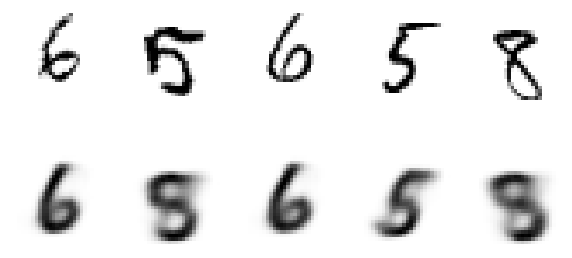

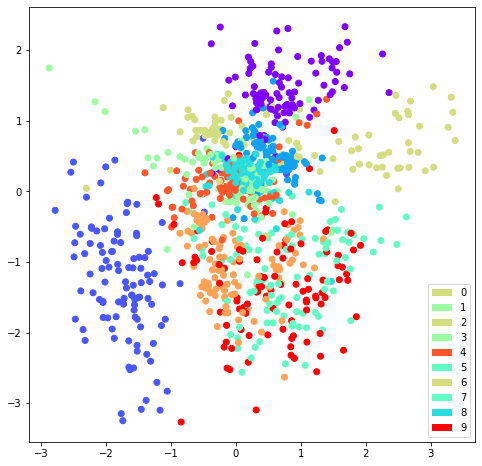

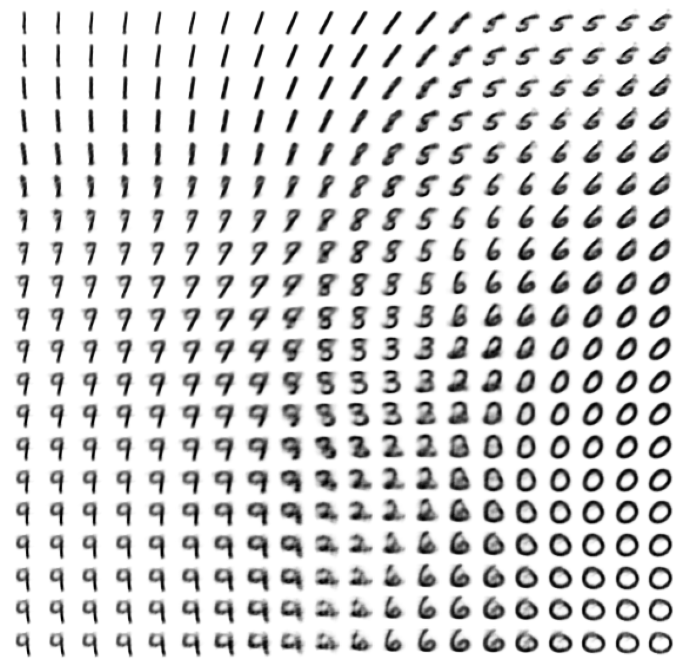

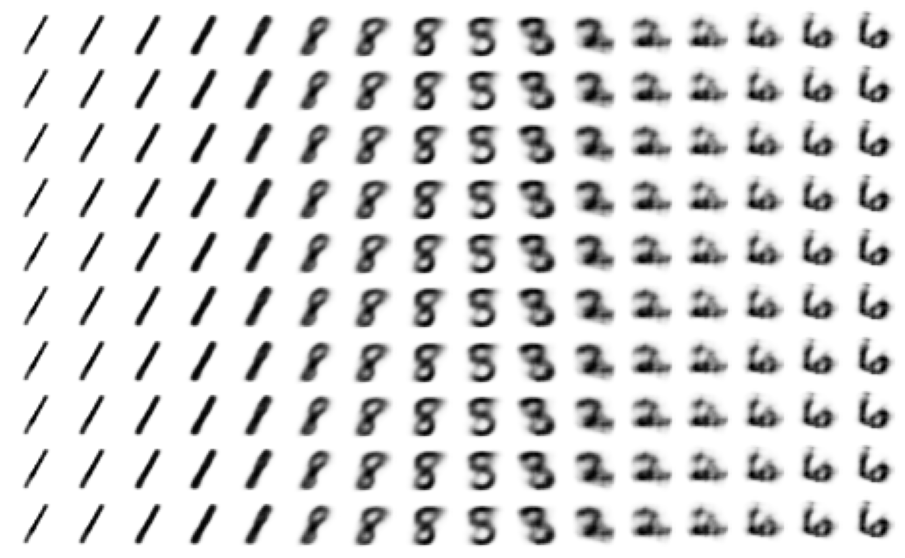

In [0]:
print ("Conv VAE ----> ")
print ("Latent Dim: ", 2)
print ("Epochs: ", 150)
train_VAE(latent_dim=2,epochs=150)

Conv VAE ----> 
Latent Dim:  0
Epochs:  150
Epoch 10, Loss: 190.7847137451172, Remaining Time at This Epoch: 6.32
Epoch 20, Loss: 173.6628875732422, Remaining Time at This Epoch: 6.31
Epoch 30, Loss: 162.1360626220703, Remaining Time at This Epoch: 6.33
Epoch 40, Loss: 160.510009765625, Remaining Time at This Epoch: 6.33
Epoch 50, Loss: 159.75177001953125, Remaining Time at This Epoch: 6.34
Epoch 60, Loss: 157.34507751464844, Remaining Time at This Epoch: 6.34
Epoch 70, Loss: 162.64199829101562, Remaining Time at This Epoch: 6.30
Epoch 80, Loss: 154.3522186279297, Remaining Time at This Epoch: 6.33
Epoch 90, Loss: 159.7234344482422, Remaining Time at This Epoch: 6.39
Epoch 100, Loss: 161.91575622558594, Remaining Time at This Epoch: 6.34
Epoch 110, Loss: 149.66468811035156, Remaining Time at This Epoch: 6.30
Epoch 120, Loss: 155.95819091796875, Remaining Time at This Epoch: 6.40
Epoch 130, Loss: 148.7919921875, Remaining Time at This Epoch: 6.32
Epoch 140, Loss: 155.8794708251953, Rema

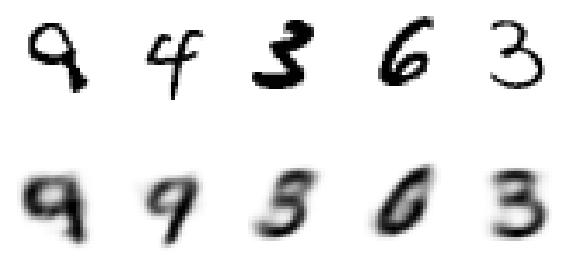

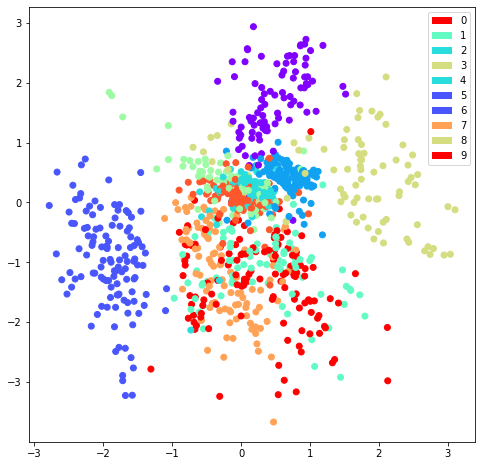

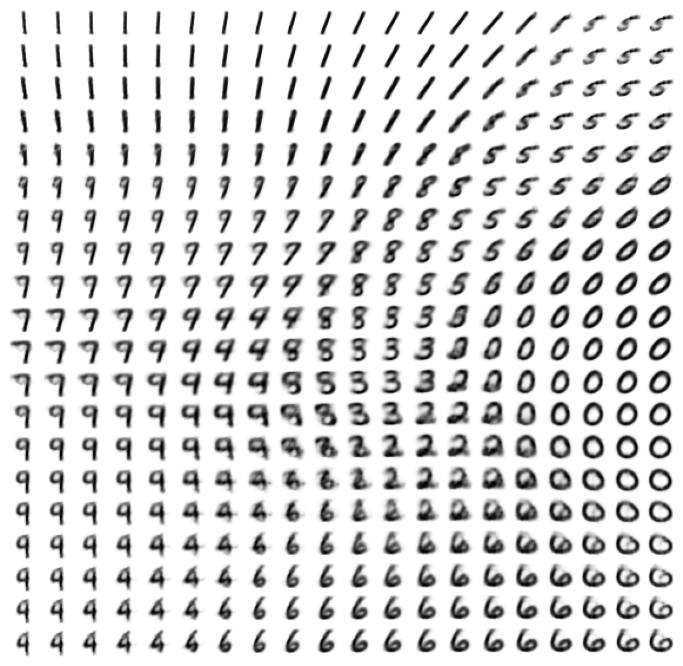

In [0]:

train_VAE(latent_dim=2,epochs=150)

# Using Higher Latent space

Conv VAE ----> 
Latent Dim:  0
Epochs:  100
Epoch 10, Loss: 167.9014892578125, Remaining Time at This Epoch: 6.40
Epoch 20, Loss: 135.332763671875, Remaining Time at This Epoch: 6.39
Epoch 30, Loss: 130.0226593017578, Remaining Time at This Epoch: 6.38
Epoch 40, Loss: 124.32096862792969, Remaining Time at This Epoch: 6.41
Epoch 50, Loss: 120.49209594726562, Remaining Time at This Epoch: 6.41
Epoch 60, Loss: 125.30723571777344, Remaining Time at This Epoch: 6.40
Epoch 70, Loss: 123.07902526855469, Remaining Time at This Epoch: 6.39
Epoch 80, Loss: 121.38968658447266, Remaining Time at This Epoch: 6.39
Epoch 90, Loss: 119.57325744628906, Remaining Time at This Epoch: 6.34
Epoch 100, Loss: 118.83493041992188, Remaining Time at This Epoch: 6.40
Epoch 110, Loss: 119.11959075927734, Remaining Time at This Epoch: 6.41
Epoch 120, Loss: 118.64996337890625, Remaining Time at This Epoch: 6.40
Epoch 130, Loss: 116.16118621826172, Remaining Time at This Epoch: 6.41
Epoch 140, Loss: 118.882476806640

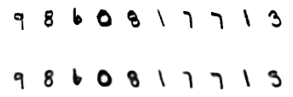

In [0]:

def plot_VAE(model, test_dataset):
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')



train_VAE(latent_dim=10,epochs=150)

Conv VAE ----> 
Latent Dim:  5
Epochs:  100
Epoch 10, Loss: 163.16513061523438, Remaining Time at This Epoch: 3.14
Epoch 20, Loss: 137.669677734375, Remaining Time at This Epoch: 3.20
Epoch 30, Loss: 135.34449768066406, Remaining Time at This Epoch: 3.24
Epoch 40, Loss: 135.15737915039062, Remaining Time at This Epoch: 3.26
Epoch 50, Loss: 132.2039031982422, Remaining Time at This Epoch: 3.25
Epoch 60, Loss: 128.45648193359375, Remaining Time at This Epoch: 3.27
Epoch 70, Loss: 131.10052490234375, Remaining Time at This Epoch: 3.27
Epoch 80, Loss: 130.33615112304688, Remaining Time at This Epoch: 3.27
Epoch 90, Loss: 127.86184692382812, Remaining Time at This Epoch: 3.27
Epoch 100, Loss: 133.0357208251953, Remaining Time at This Epoch: 3.25
Epoch 110, Loss: 127.15782165527344, Remaining Time at This Epoch: 3.26
Epoch 120, Loss: 126.17071533203125, Remaining Time at This Epoch: 3.27
Epoch 130, Loss: 126.32884216308594, Remaining Time at This Epoch: 3.28
Epoch 140, Loss: 124.274185180664

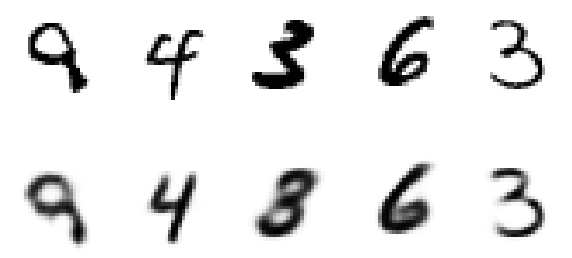

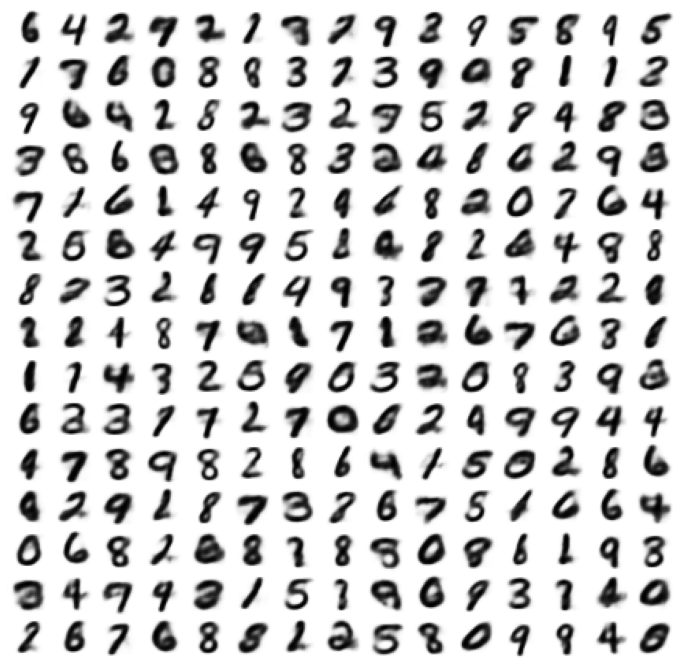

In [0]:

def plot_VAE(model, test_dataset):
    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=5)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')

train_VAE(latent_dim=5,epochs=150) 

Conv VAE ----> 
Latent Dim:  10
Epochs:  100
Epoch 10, Loss: 170.17262268066406, Remaining Time at This Epoch: 3.15
Epoch 20, Loss: 132.19677734375, Remaining Time at This Epoch: 3.22
Epoch 30, Loss: 128.1134796142578, Remaining Time at This Epoch: 3.26
Epoch 40, Loss: 126.47244262695312, Remaining Time at This Epoch: 3.24
Epoch 50, Loss: 124.9742431640625, Remaining Time at This Epoch: 3.25
Epoch 60, Loss: 123.28471374511719, Remaining Time at This Epoch: 3.28
Epoch 70, Loss: 123.55437469482422, Remaining Time at This Epoch: 3.27
Epoch 80, Loss: 122.35216522216797, Remaining Time at This Epoch: 3.24
Epoch 90, Loss: 122.86471557617188, Remaining Time at This Epoch: 3.24
Epoch 100, Loss: 121.14140319824219, Remaining Time at This Epoch: 3.25
Epoch 110, Loss: 118.66555786132812, Remaining Time at This Epoch: 3.25
Epoch 120, Loss: 120.4168472290039, Remaining Time at This Epoch: 3.24
Epoch 130, Loss: 118.27690887451172, Remaining Time at This Epoch: 3.24
Epoch 140, Loss: 119.7686462402343

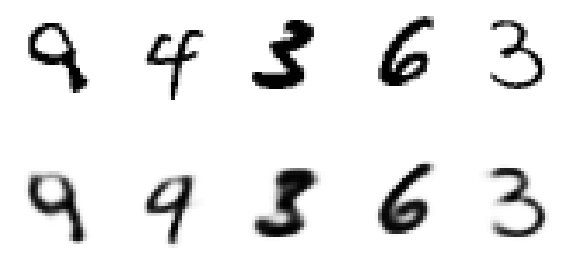

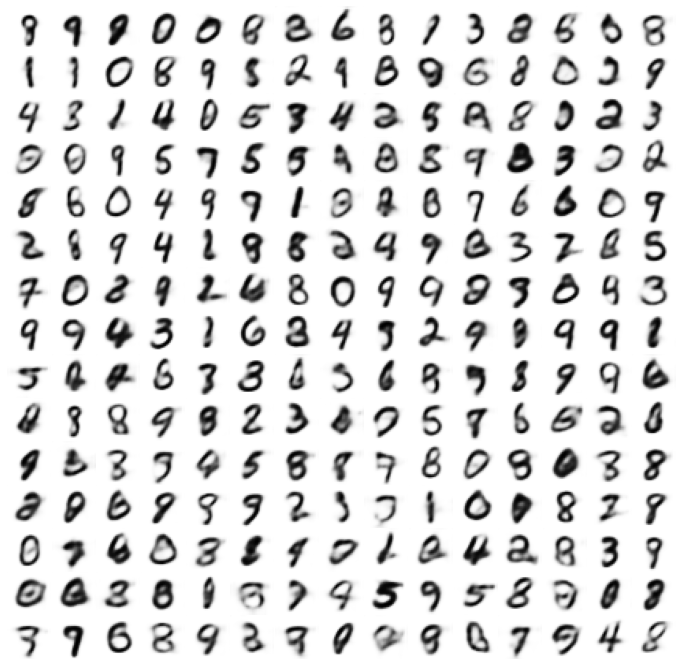

In [0]:

def plot_VAE(model, test_dataset):
    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=10)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')


  
print ("Conv VAE ----> ")
print ("Latent Dim: ", 10)
print ("Epochs: ", 100)
train_VAE(latent_dim=10,epochs=150)

Conv VAE ----> 
Latent Dim:  19
Epochs:  100
Epoch 10, Loss: 174.94808959960938, Remaining Time at This Epoch: 2.04
Epoch 20, Loss: 133.903076171875, Remaining Time at This Epoch: 2.05
Epoch 30, Loss: 129.5440216064453, Remaining Time at This Epoch: 2.06
Epoch 40, Loss: 125.509521484375, Remaining Time at This Epoch: 2.05
Epoch 50, Loss: 127.11955261230469, Remaining Time at This Epoch: 2.04
Epoch 60, Loss: 124.81257629394531, Remaining Time at This Epoch: 2.07
Epoch 70, Loss: 120.05149841308594, Remaining Time at This Epoch: 2.05
Epoch 80, Loss: 122.0544662475586, Remaining Time at This Epoch: 2.03
Epoch 90, Loss: 120.2235107421875, Remaining Time at This Epoch: 2.05
Epoch 100, Loss: 118.44499206542969, Remaining Time at This Epoch: 2.04
Epoch 110, Loss: 119.68148803710938, Remaining Time at This Epoch: 2.03
Epoch 120, Loss: 120.03727722167969, Remaining Time at This Epoch: 2.03
Epoch 130, Loss: 119.34950256347656, Remaining Time at This Epoch: 2.04
Epoch 140, Loss: 120.97188568115234

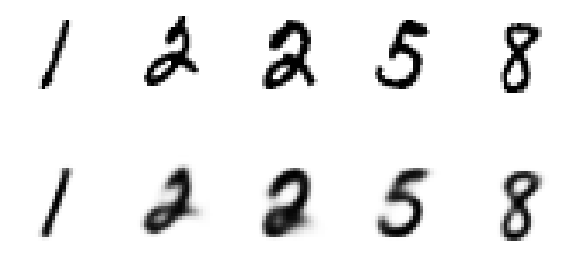

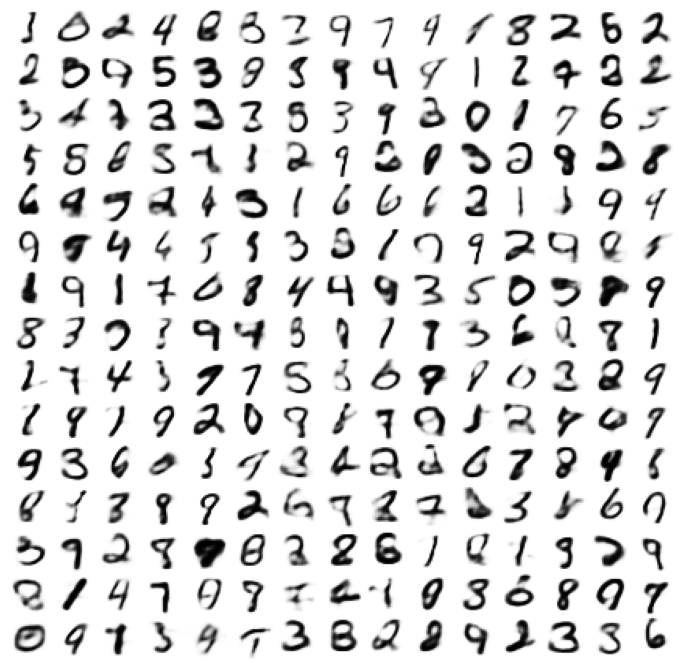

In [0]:

def plot_VAE(model, test_dataset):
    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=10)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')

print ("Conv VAE ----> ")
print ("Latent Dim: ", i)
print ("Epochs: ", 100)
train_VAE(latent_dim=10,epochs=1)

Conv VAE ----> 
Latent Dim:  19
Epochs:  100
Epoch 10, Loss: 177.33155822753906, Remaining Time at This Epoch: 2.03
Epoch 20, Loss: 138.4820098876953, Remaining Time at This Epoch: 2.03
Epoch 30, Loss: 133.6522216796875, Remaining Time at This Epoch: 2.04
Epoch 40, Loss: 125.97817993164062, Remaining Time at This Epoch: 2.03
Epoch 50, Loss: 127.71073913574219, Remaining Time at This Epoch: 2.03
Epoch 60, Loss: 124.98607635498047, Remaining Time at This Epoch: 2.03
Epoch 70, Loss: 124.20567321777344, Remaining Time at This Epoch: 2.05
Epoch 80, Loss: 120.6591567993164, Remaining Time at This Epoch: 2.05
Epoch 90, Loss: 122.21991729736328, Remaining Time at This Epoch: 2.04
Epoch 100, Loss: 117.91522216796875, Remaining Time at This Epoch: 2.04
Epoch 110, Loss: 118.24594116210938, Remaining Time at This Epoch: 2.06
Epoch 120, Loss: 120.38751983642578, Remaining Time at This Epoch: 2.04
Epoch 130, Loss: 119.88776397705078, Remaining Time at This Epoch: 2.07
Epoch 140, Loss: 117.7187652587

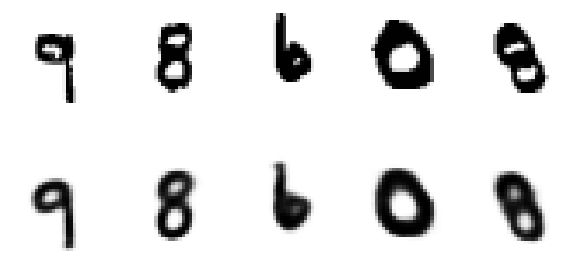

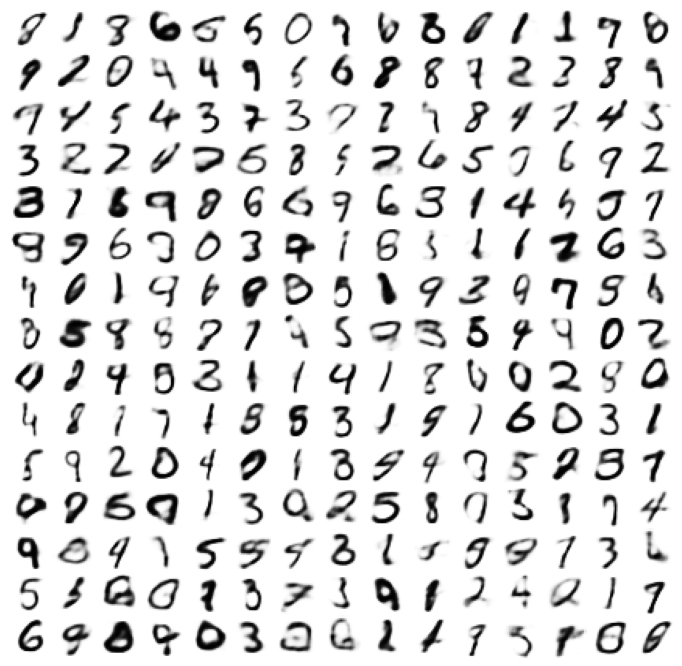

In [0]:

def plot_VAE(model, test_dataset):
    if not os.path.exists("results"):
        os.makedirs("results")
    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=10)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')

print ("Conv VAE ----> ")
print ("Latent Dim: ", i)
print ("Epochs: ", 100)
train_VAE(latent_dim=10,epochs=150)

Conv VAE ----> 
Latent Dim:  19
Epochs:  100
Epoch 10, Loss: 179.63302612304688, Remaining Time at This Epoch: 2.04
Epoch 20, Loss: 146.49383544921875, Remaining Time at This Epoch: 2.03
Epoch 30, Loss: 136.23263549804688, Remaining Time at This Epoch: 2.04
Epoch 40, Loss: 136.05746459960938, Remaining Time at This Epoch: 2.04
Epoch 50, Loss: 132.9044189453125, Remaining Time at This Epoch: 2.05
Epoch 60, Loss: 131.28744506835938, Remaining Time at This Epoch: 2.05
Epoch 70, Loss: 135.3391876220703, Remaining Time at This Epoch: 2.04
Epoch 80, Loss: 130.60748291015625, Remaining Time at This Epoch: 2.05
Epoch 90, Loss: 128.7716827392578, Remaining Time at This Epoch: 2.04
Epoch 100, Loss: 133.65850830078125, Remaining Time at This Epoch: 2.04
Epoch 110, Loss: 127.41300201416016, Remaining Time at This Epoch: 2.04
Epoch 120, Loss: 127.86515045166016, Remaining Time at This Epoch: 2.04
Epoch 130, Loss: 125.85870361328125, Remaining Time at This Epoch: 2.04
Epoch 140, Loss: 127.7216339111

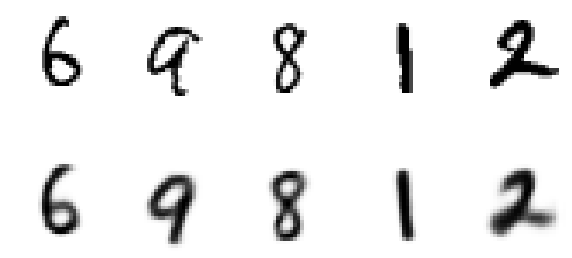

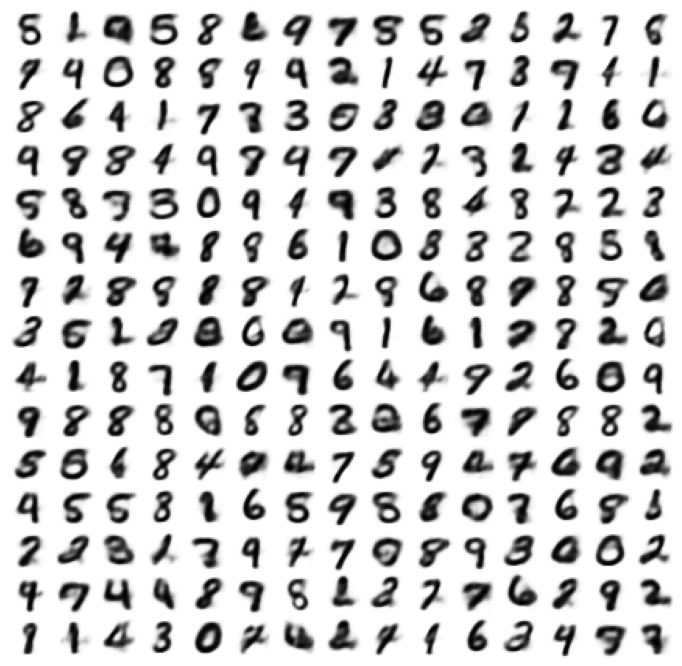

In [0]:

def plot_VAE(model, test_dataset):
    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=5)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')

print ("Conv VAE ----> ")
print ("Latent Dim: ", i)
print ("Epochs: ", 100)
train_VAE(latent_dim=5,epochs=150)

Conv VAE ----> 
Latent Dim:  2
Epochs:  100
Epoch 10, Loss: 190.32772827148438, Remaining Time at This Epoch: 2.05
Epoch 20, Loss: 174.7166290283203, Remaining Time at This Epoch: 2.02
Epoch 30, Loss: 173.86341857910156, Remaining Time at This Epoch: 2.03
Epoch 40, Loss: 163.7732391357422, Remaining Time at This Epoch: 2.03
Epoch 50, Loss: 168.74459838867188, Remaining Time at This Epoch: 2.02
Epoch 60, Loss: 159.6580810546875, Remaining Time at This Epoch: 2.03
Epoch 70, Loss: 157.9800262451172, Remaining Time at This Epoch: 2.02
Epoch 80, Loss: 156.5351104736328, Remaining Time at This Epoch: 2.02
Epoch 90, Loss: 159.6021270751953, Remaining Time at This Epoch: 2.03
Epoch 100, Loss: 157.128173828125, Remaining Time at This Epoch: 2.03
Epoch 110, Loss: 160.04693603515625, Remaining Time at This Epoch: 2.02
Epoch 120, Loss: 158.577392578125, Remaining Time at This Epoch: 2.04
Epoch 130, Loss: 155.826171875, Remaining Time at This Epoch: 2.03
Epoch 140, Loss: 157.70504760742188, Remaini

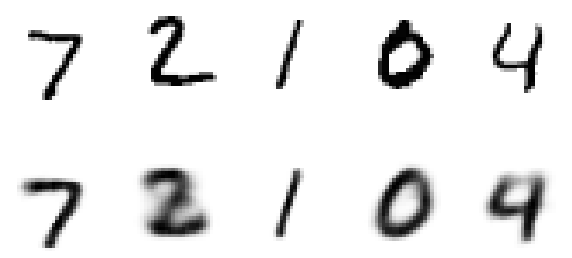

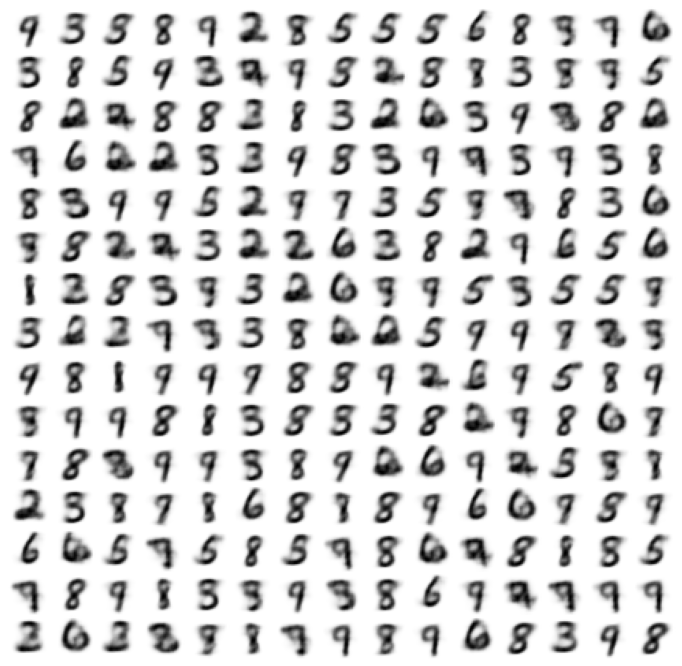

In [0]:

def plot_VAE(model, test_dataset):

    # --- Reconstruction plot ---
    n = 5
    sample_dataset = test_dataset
    x_input, y_input = next(sample_dataset.__iter__())
    x_input_sample, y_input_sample = map(lambda x: x[:n], (x_input, y_input))
    z = model.encode(x_input_sample)[0].numpy()

    fig, axarr = plt.subplots(2, 5, figsize=(10, 5))
    x_input_sample = x_input_sample.numpy().reshape([n, 28, 28])
    x_output = model.decode(z, apply_sigmoid=True).numpy().reshape([n, 28, 28])

    for i in range(n):
        axarr[0, i].axis('off')
        axarr[1, i].axis('off')
        axarr[0, i].imshow(x_input_sample[i], cmap='binary')
        axarr[1, i].imshow(x_output[i], cmap='binary')

    n = 15
    import numpy as np
    f, axarr = plt.subplots(n, n, figsize=(12, 12))
    f.subplots_adjust(hspace=0., wspace=-0.)
    for i in range(0,n):
        for j in range(0,n):
          # print (i, " ", j)
          z = np.array([np.random.uniform(-2, 2, size=2)])
          generated_img = model.decode(z, apply_sigmoid=True).numpy().reshape([28, 28])
          axarr[i, j].axis('off')
          axarr[i, j].imshow(generated_img, cmap='binary')

print ("Conv VAE ----> ")
print ("Latent Dim: ", 2)
print ("Epochs: ", 100)
train_VAE(latent_dim=2,epochs=150)